2 The Support Vector Machine (SVM) (part 1/2)
-------------------
Following the previous session of using **linear** methods for finding the **decision boundaries** in **supervised learning**, this session will continue with **supervised** algorithm, where you will be seeking to maximize the separation of classes as well as to deal with **non-linear** classification.

As you have already noticed that there are few different approaches to identify the **decision boundaries**. Such as the statistical (**EM**) and non-statistical (**linear perceptron**) approaches shown in the previous sessions. Some of the models approach the **decision boundaries** by minimizing the intra-class variance while maximizing the inter-class variance by solving a linear function, such as the **linear discriminant functions**, others iteratively update the model while seeking **decision boundaries**. These approaches would provide you with various results of **decision boundaries**. In this session, you will be looking at classification problem from yet another perspective: seeking the **decision boundaries** by maximizing the margins of classes. This is exactly the rationale of the **support vector machine** (**SVM**), which seeks the **decision boundary** lying in the center of the largest gap between classes. To achieve this, the **SVM** would identify the margin of classes by picking the data points that define the margin of classes, and solve the **decision boundary** as the center line of the largest gap between these picked data points. These picked data points as define the margin of the classess are referred as the **support vectors**, which controls the position of the **decision boundaries**. Thus, the **SVM** is not depending on all the data points in a dataset.

One of the strength of the **SVM** is its capability of dealing with non-linear **decision boundaries**. The **SVM** can leverage a **kernel transformation** and project the feature space into some other and potentially higher dimensional feature space, where the data points can be classified linearly by a linear **hyperplane** defined by the **SVM**. This is equivalent to identify a non-linear classification in the original feature space.

You will again follow the same scheme, where you start with artificially generated dummy data and try to understand how the **SVM** works. Then you will apply the **SVM** to the real world dataset. Structure of this session will be:

- 2.0 Understanding the SVM through dummy dataset
- 2.1 Applying the SVM through existing module(s)
- 2.2 Dealing with non-linearity
- 2.3 The SVM on real world GIS and Remote Sensing datasets
- 2.4 Model evaluation

In this notebook, you will focus on the first 3 sections with the dummy dataset. In another notebook (part 2/2), you will continue with the **SVM** on real world land use and land cover (LULC) dataset of the Netherlands.

In [1]:
# In order to plot figures inline in Jupyter Notebook, 
# we need to run this. But please ignore this in Colab.
%matplotlib inline

### 2.0 Understanding the SVM through dummy dataset

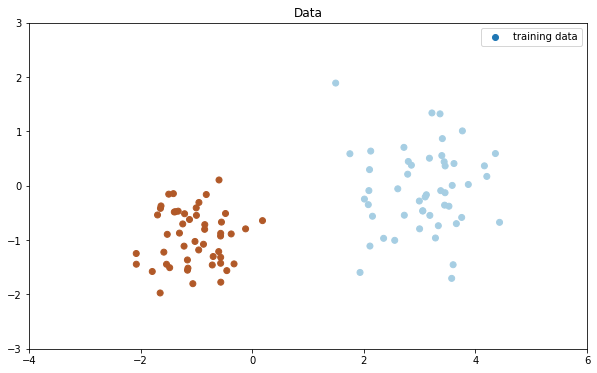

In [2]:
# Start with some dummy data points.
import numpy as np
import matplotlib.pyplot as plt

# You can define a function to create your dummy dataset.
# This time, we intensionally create a dataset with clear gaps between classes for the ease of visualizing SVM classifier.
def dummyData(add_outliers=False, add_class=False):
    x0 = np.random.randn(50, 2) * 0.7 + np.array([3.0, 0.0])
    x1 = np.random.randn(50, 2) * 0.5 + np.array([-1.0, -1.0])
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(len(x0)), np.ones(len(x1))]).astype(np.int)

# Then, try to call the function to create some data.
x_train, y_train = dummyData()

# Visualize the dummy dataset.
plt.figure(figsize=(10,6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.axis([-4, 6, -3, 3])
plt.title('Data')
plt.legend()

In [3]:
# You then need to create training and test dataset out of the original dummy dataset.
# You can define a function to split the dataset at hand.
def trainTestSplit(x, y):
    data = np.c_[x, y]
    np.random.shuffle(data)
    x_train = data[:int(0.7*len(data)), :2]  # 70% of data for training
    x_test = data[int(0.7*len(data)):, :2]  # 30% for testing
    y_train = data[:int(0.7*len(data)), 2:]  # 70% of data for training
    y_train = y_train.reshape(-1,)
    y_test = data[int(0.7*len(data)):, 2:]  # 30% for testing
    y_test = y_test.reshape(-1,)
    return x_train, y_train, x_test, y_test

# Apply the function to your data.
X_train, Y_train, X_test, Y_test = trainTestSplit(x_train, y_train)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(70, 2) (70,) (30, 2) (30,)


In [4]:
# Function for training/fitting the SVM classifier.
def train(X, y, lr, n_iters):
    n_samples, n_features = X.shape
    y_ = np.where(y <= 0, -1, 1)
    w = np.zeros(n_features)
    b = 0

    w_all=[]
    b_all=[]
    for _ in range(n_iters):
        for idx, x_i in enumerate(X):
            condition = y_[idx] * (np.dot(x_i, w) - b) >= 1
            if condition:
                w -= lr * (2 * lambda_param * w)
            else:
                w -= lr * (2 * lambda_param * w - np.dot(x_i, y_[idx]))
                b -= lr * y_[idx]
        w_all.append(w)
        b_all.append(b)
    return w, b, w_all, b_all

# Function for applying the trained model for making predictions. 
def predict(X, w, b):
    approx = np.dot(X, w) - b
    return np.sign(approx)


In [5]:
# Deploy training over the training data.
learning_rate=0.001
lambda_param=0.01
n_iters=500

weights, bias, w_all, b_all = train(X_train, Y_train, learning_rate, n_iters)
print(weights, bias)

[-1.01069085 -0.08257565] -0.8180000000000006


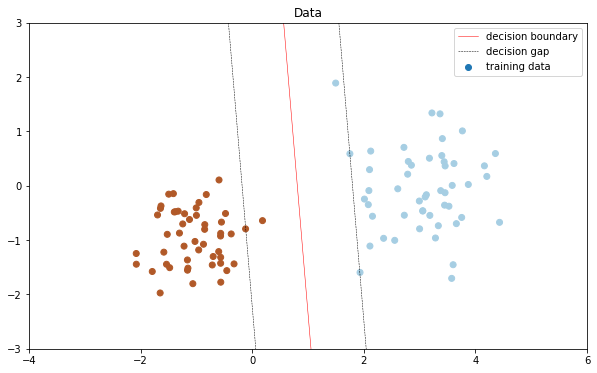

In [6]:
# Visualize the results.

# Function for drawing the largest gap identified by the SVM.
def get_hyperplane_value(x, w, b, offset):
    return (-w[0] * x + b + offset) / w[1]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')

x0_1 = np.amin(X_train[:,0])
x0_2 = np.amax(X_train[:,0])

x1_1 = get_hyperplane_value(x0_1, weights, bias, 0)
x1_2 = get_hyperplane_value(x0_2, weights, bias, 0)

x1_1_m = get_hyperplane_value(x0_1, weights, bias, -1)
x1_2_m = get_hyperplane_value(x0_2, weights, bias, -1)

x1_1_p = get_hyperplane_value(x0_1, weights, bias, 1)
x1_2_p = get_hyperplane_value(x0_2, weights, bias, 1)

ax.plot([x0_1, x0_2],[x1_1, x1_2], 'r-', linewidth=.5, label='decision boundary')
ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k--', linewidth=.5, label='decision gap')
ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k--', linewidth=.5)

x1_min = np.amin(X_train[:,1])
x1_max = np.amax(X_train[:,1])
ax.set_ylim([x1_min-3,x1_max+3])

plt.axis([-4, 6, -3, 3])
plt.title('Data')
plt.legend()


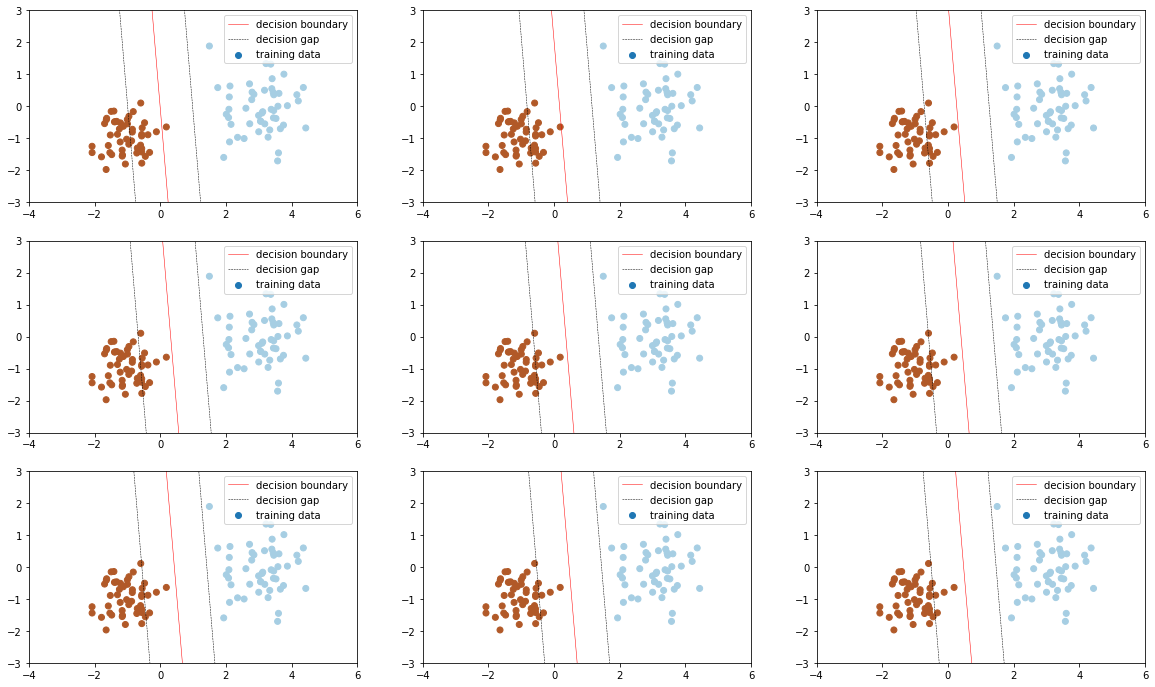

In [7]:
# Visualize the steps of how the SVM is trained.
fig = plt.figure(figsize=(20,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')

    x0_1 = np.amin(X_train[:,0])
    x0_2 = np.amax(X_train[:,0])
    
    weights, bias = w_all[i*10], b_all[i*10]

    x1_1 = get_hyperplane_value(x0_1, weights, bias, 0)
    x1_2 = get_hyperplane_value(x0_2, weights, bias, 0)

    x1_1_m = get_hyperplane_value(x0_1, weights, bias, -1)
    x1_2_m = get_hyperplane_value(x0_2, weights, bias, -1)

    x1_1_p = get_hyperplane_value(x0_1, weights, bias, 1)
    x1_2_p = get_hyperplane_value(x0_2, weights, bias, 1)

    plt.plot([x0_1, x0_2],[x1_1, x1_2], 'r-', linewidth=.5, label='decision boundary')
    plt.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k--', linewidth=.5, label='decision gap')
    plt.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k--', linewidth=.5)

    x1_min = np.amin(X_train[:,1])
    x1_max = np.amax(X_train[:,1])
    plt.ylim([x1_min-3,x1_max+3])

    plt.axis([-4, 6, -3, 3])
    plt.legend()

In [8]:
# Do you also want to test your trained model? Please experiment it with the test data.

### 2.1 Applying the SVM through existing module(s).

In [9]:
# After knowing the rationale of the SVM, you don't have to bother writing it by yourself everytime.
# There are already packages and modules that have implemented SVM.
# For instance, again, the sklearn includes a SVM module that contains variations of SVM models.

from sklearn.svm import SVC  # Support vector classifier

svm_lin = SVC(kernel='linear', C=1E10)
svm_lin.fit(X_train, Y_train)

print('Linear SVM bias: ', svm_lin.intercept_)
print('Linear SVM weights: ', svm_lin.coef_)

Linear SVM bias:  [1.15797204]
Linear SVM weights:  [[-1.19833782 -0.09989675]]


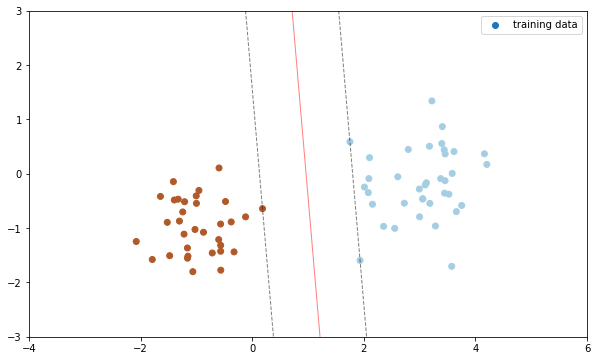

In [10]:
# You can of course again define a function to visualize the results from the sklearn SVM.
# This time you can also try to highlight the support vectors.

def plot_svc_decision_function(model, ax=None, plot_support=True):
    '''Plot the decision function for a 2D SVC'''
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors=['k','r','k'],
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'], linewidths=1.0)
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig = plt.figure(figsize=(10,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
plt.axis([-4, 6, -3, 3])
plot_svc_decision_function(svm_lin)
plt.legend()

### 2.2 Dealing with non-linearity

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


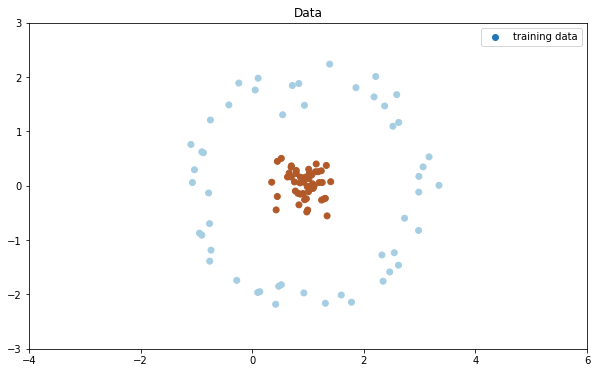

In [11]:
# It is not always ideal to have a linear classifier to make a clean separation.
# You will have to add some non-linearity to your model to make classification flexible.
# You can easily achieve non-linear classification through adding kernels to your SVM.

# Let's look at some dummy data points generated from sklearn that are less likely to be classified linearly.
from sklearn.datasets.samples_generator import make_circles
X_train, Y_train = make_circles(100, factor=.1, noise=.1)
X_train = X_train*2 + np.c_[np.ones(len(X_train)), np.zeros(len(X_train))]

# Visualize the dummy dataset.
plt.figure(figsize=(10,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
plt.axis([-4, 6, -3, 3])
plt.title('Data')
plt.legend()

Linear SVM bias:  [1.15797204]
Linear SVM weights:  [[-1.19833782 -0.09989675]]


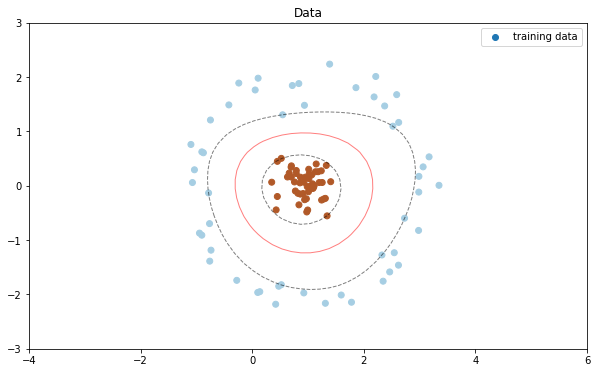

In [12]:
# Try to figure out how the kernel works.
# Could you go online and refer to the sklearn documentation for other potentially useful kernels?
svm_kern = SVC(kernel='rbf', C=1E6)
svm_kern.fit(X_train, Y_train)

print('Linear SVM bias: ', svm_lin.intercept_)
print('Linear SVM weights: ', svm_lin.coef_)

# Visualize the classification result of the dummy dataset.
plt.figure(figsize=(10,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
plot_svc_decision_function(svm_kern)
plt.axis([-4, 6, -3, 3])
plt.title('Data')
plt.legend()
